# Non-Periodic Boundary Conditions

This tutorial demonstrates how to simulate polymers with **non-periodic boundary conditions**, which are essential for modeling confined systems like thin films, surfaces, and interfaces.

**What you'll learn:**
- Reflecting (Neumann) boundary conditions: symmetry planes
- Absorbing (Dirichlet) boundary conditions: impenetrable walls
- Mixed boundary conditions: combining different BC types
- Physical interpretation of each boundary condition

**Prerequisites:** Complete `00_QuickStart.ipynb` and `Diblock.ipynb` first.

## 1. Setup

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"      # Optimize threading
os.environ["OMP_NUM_THREADS"] = "1"      # Single-threaded FFT

import numpy as np
import matplotlib.pyplot as plt
from polymerfts import PropagatorSolver

print("Ready to explore non-periodic boundary conditions!")

Ready to explore non-periodic boundary conditions!


## 2. Overview of Boundary Conditions

The standard pseudo-spectral method uses DFT, which implicitly imposes **periodic** boundary conditions. For confined systems, we need different options:

| Boundary Condition | Mathematical Form | Physical Meaning | Numerical Transform |
|-------------------|-------------------|------------------|---------------------|
| **Periodic** | $q(0) = q(L)$ | Bulk polymer (infinite system) | DFT |
| **Reflecting** (Neumann) | $\frac{\partial q}{\partial n} = 0$ | Symmetry plane | DCT |
| **Absorbing** (Dirichlet) | $q = 0$ | Impenetrable wall | DST |

### Physical Intuition

**Reflecting BC:** Zero flux at the boundary. In polymer field theory, this is primarily used for **symmetry planes** — allowing you to simulate only half of a symmetric system to reduce computational cost. For example, the midplane between two opposing polymer brushes.

**Absorbing BC:** The propagator is forced to zero at the boundary, meaning polymer segments **cannot exist at the wall**. This is the correct condition for truly impenetrable/hard walls. **Mass decreases** because chain conformations that would place any segment at the wall are excluded.

### BC Format in PropagatorSolver

Boundary conditions are specified as a list of strings:
- **1D**: `[x_low, x_high]`
- **2D**: `[x_low, x_high, y_low, y_high]`
- **3D**: `[x_low, x_high, y_low, y_high, z_low, z_high]`

Each element can be: `"periodic"`, `"reflecting"`, or `"absorbing"`

## 3. Reflecting Boundary Conditions

**Physical interpretation:** Zero flux at the boundary ($\partial q/\partial n = 0$). In polymer field theory, reflecting BC is used for **symmetry planes** to reduce computational cost by simulating only half of a symmetric system.

**Mathematical condition:** $\frac{\partial q}{\partial n} = 0$ (zero flux normal to the boundary)

**Key property:** Mass is conserved throughout the simulation.

In [2]:
# Create solver with reflecting BC on both sides
N = 64
L = 4.0
ds = 0.01

solver_reflect = PropagatorSolver(
    nx=[N], lx=[L],
    ds=ds,
    bond_lengths={"A": 1.0},
    bc=["reflecting", "reflecting"],  # Symmetry planes (zero flux)
    chain_model="continuous",
    method="pseudospectral",
    reduce_memory=False
)
solver_reflect.add_polymer(1.0, [["A", 1.0, 0, 1]])

print(solver_reflect.info)

PropagatorSolver Configuration:
  Dimensions: 1D
  Grid: [64]
  Box size: [4.0]
  Boundary conditions: ['reflecting', 'reflecting']
  Chain model: continuous
  Contour step (ds): 0.01
  Method: pseudospectral
  Platform: cpu-fftw
  Monomer types: ['A']


In [3]:
# Zero potential (free diffusion)
w = np.zeros(N)
solver_reflect.compute_propagators({"A": w})

# Get propagators at different contour positions
n_segments = int(1.0 / ds)  # 100 segments for ds=0.01
dx = L / N
x = np.linspace(dx/2, L - dx/2, N)

# Collect propagators and track mass at different steps
step_indices = [0, 20, 50, 100]
snapshots = []
masses = []

for step in range(n_segments + 1):
    q = solver_reflect.get_propagator(polymer=0, v=0, u=1, step=step)
    masses.append(np.sum(q) * dx)
    if step in step_indices:
        snapshots.append((step, q.copy()))

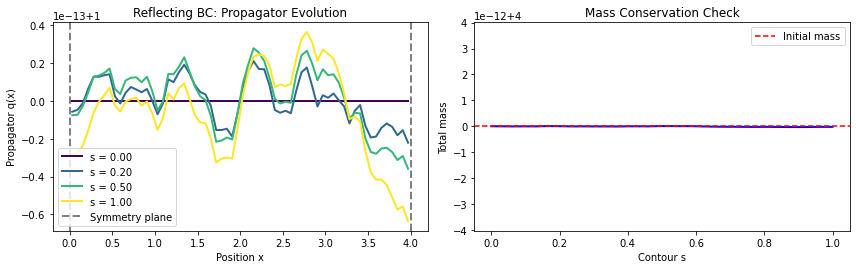


Mass conservation error: 5.88e-15
Result: Mass is CONSERVED with reflecting BC (as expected)


In [4]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Propagator evolution
colors = plt.cm.viridis(np.linspace(0, 1, len(snapshots)))
for (step, snap), color in zip(snapshots, colors):
    axes[0].plot(x, snap, color=color, linewidth=2, label=f's = {step*ds:.2f}')

axes[0].axvline(x=0, color='gray', linestyle='--', linewidth=2, label='Symmetry plane')
axes[0].axvline(x=L, color='gray', linestyle='--', linewidth=2)
axes[0].set(xlabel='Position x', ylabel='Propagator q(x)', 
            title='Reflecting BC: Propagator Evolution')
axes[0].legend()
axes[0].set_xlim(-0.2, L + 0.2)

# Right: Mass conservation
axes[1].plot(np.arange(len(masses)) * ds, masses, 'b-', linewidth=2)
axes[1].axhline(y=masses[0], color='r', linestyle='--', label='Initial mass')
axes[1].set(xlabel='Contour s', ylabel='Total mass', 
            title='Mass Conservation Check')
axes[1].legend()

plt.tight_layout()
plt.show()

mass_error = abs(masses[-1] - masses[0]) / masses[0]
print(f"\nMass conservation error: {mass_error:.2e}")
print("Result: Mass is CONSERVED with reflecting BC (as expected)")

## 4. Absorbing Boundary Conditions

**Physical interpretation:** The propagator is forced to zero at the boundary, meaning **polymer segments cannot exist at the wall**. This is the correct condition for impenetrable/hard walls in polymer field theory.

**Mathematical condition:** $q = 0$ at the boundary

**Key property:** Mass decreases because chain conformations that would place any segment at the wall are excluded from the ensemble.

In [5]:
# Create solver with absorbing BC
solver_absorb = PropagatorSolver(
    nx=[N], lx=[L],
    ds=ds,
    bond_lengths={"A": 1.0},
    bc=["absorbing", "absorbing"],  # Impenetrable walls (q=0)
    chain_model="continuous",
    method="pseudospectral",
    reduce_memory=False
)
solver_absorb.add_polymer(1.0, [["A", 1.0, 0, 1]])
solver_absorb.compute_propagators({"A": w})

# Collect propagators and track mass at different steps
snapshots_absorb = []
masses_absorb = []

for step in range(n_segments + 1):
    q = solver_absorb.get_propagator(polymer=0, v=0, u=1, step=step)
    masses_absorb.append(np.sum(q) * dx)
    if step in step_indices:
        snapshots_absorb.append((step, q.copy()))

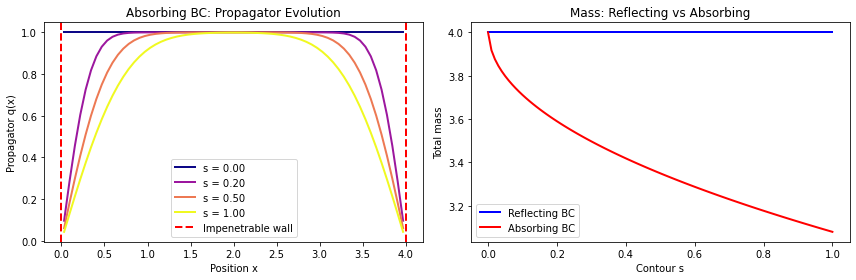


Final mass / Initial mass = 0.7699
Mass excluded: 23.0%
Result: Mass DECREASES with absorbing BC (conformations touching walls are excluded)


In [6]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Propagator evolution
colors = plt.cm.plasma(np.linspace(0, 1, len(snapshots_absorb)))
for (step, snap), color in zip(snapshots_absorb, colors):
    axes[0].plot(x, snap, color=color, linewidth=2, label=f's = {step*ds:.2f}')

axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Impenetrable wall')
axes[0].axvline(x=L, color='red', linestyle='--', linewidth=2)
axes[0].set(xlabel='Position x', ylabel='Propagator q(x)', 
            title='Absorbing BC: Propagator Evolution')
axes[0].legend()
axes[0].set_xlim(-0.2, L + 0.2)

# Right: Mass comparison
s_values = np.arange(len(masses)) * ds
axes[1].plot(s_values, masses, 'b-', linewidth=2, label='Reflecting BC')
axes[1].plot(s_values, masses_absorb, 'r-', linewidth=2, label='Absorbing BC')
axes[1].set(xlabel='Contour s', ylabel='Total mass', 
            title='Mass: Reflecting vs Absorbing')
axes[1].legend()

plt.tight_layout()
plt.show()

mass_ratio = masses_absorb[-1] / masses_absorb[0]
print(f"\nFinal mass / Initial mass = {mass_ratio:.4f}")
print(f"Mass excluded: {(1 - mass_ratio) * 100:.1f}%")
print("Result: Mass DECREASES with absorbing BC (conformations touching walls are excluded)")

## 5. Mixed Boundary Conditions (2D)

In real applications, different boundaries may require different conditions. **Mixed boundary conditions** let you model these systems.

**Example: Half-domain simulation with hard walls**
- **X-direction:** Reflecting — symmetry planes (simulate half the domain)
- **Y-direction:** Absorbing — impenetrable top/bottom walls

In [7]:
# 2D solver with mixed BC
NX, NY = 32, 24
LX, LY = 4.0, 3.0

solver_mixed = PropagatorSolver(
    nx=[NX, NY], lx=[LX, LY],
    ds=ds,
    bond_lengths={"A": 1.0},
    bc=["reflecting", "reflecting",   # X: symmetry planes
        "absorbing", "absorbing"],    # Y: impenetrable walls
    chain_model="continuous",
    method="pseudospectral",
    reduce_memory=False
)
solver_mixed.add_polymer(1.0, [["A", 1.0, 0, 1]])

print(solver_mixed.info)

PropagatorSolver Configuration:
  Dimensions: 2D
  Grid: [32, 24]
  Box size: [4.0, 3.0]
  Boundary conditions: ['reflecting', 'reflecting', 'absorbing', 'absorbing']
  Chain model: continuous
  Contour step (ds): 0.01
  Method: pseudospectral
  Platform: cpu-fftw
  Monomer types: ['A']


In [8]:
# Zero potential
M = NX * NY
w_2d = np.zeros(M)
solver_mixed.compute_propagators({"A": w_2d})

# Get propagators at different contour positions
n_segments_2d = int(1.0 / ds)
step_indices_2d = [0, 10, 25, 50]
snapshots_2d = []

for step in step_indices_2d:
    q = solver_mixed.get_propagator(polymer=0, v=0, u=1, step=step)
    snapshots_2d.append((step, q.reshape(NX, NY)))

# Grid coordinates for plotting
dx, dy = LX/NX, LY/NY
x_2d = np.linspace(dx/2, LX - dx/2, NX)
y_2d = np.linspace(dy/2, LY - dy/2, NY)

In [ ]:
# Visualize 2D evolution
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

titles = [f's = {s*ds:.2f}' for s, _ in snapshots_2d]
vmax = np.max([np.max(snap) for _, snap in snapshots_2d])

for ax, (step, snap), title in zip(axes, snapshots_2d, titles):
    im = ax.imshow(snap.T, origin='lower', extent=[0, LX, 0, LY],
                   cmap='hot', vmin=0, vmax=vmax)
    ax.set(xlabel='x', ylabel='y', title=title)
    
    # Mark boundary types
    ax.axhline(y=0, color='red', linestyle='-', linewidth=3, alpha=0.7)
    ax.axhline(y=LY, color='red', linestyle='-', linewidth=3, alpha=0.7)
    ax.axvline(x=0, color='blue', linestyle='-', linewidth=3, alpha=0.7)
    ax.axvline(x=LX, color='blue', linestyle='-', linewidth=3, alpha=0.7)

fig.suptitle('Mixed BC: Symmetry (blue) in X, Impenetrable (red) in Y', fontsize=14)
fig.subplots_adjust(right=0.92)
fig.colorbar(im, ax=axes.ravel().tolist(), label='q(r, s)', shrink=0.8)
plt.show()

print("\nObservation:")
print("  - The propagator spreads in X (reflecting BC preserves mass)")
print("  - The propagator is excluded from Y boundaries (absorbing BC)")
print("  - X-symmetry is preserved (symmetric initial condition + reflecting BC)")

## 6. Comparison of Numerical Methods

For non-periodic boundary conditions, two numerical methods are available:

| Method | Transform | Accuracy | Speed |
|--------|-----------|----------|-------|
| **Pseudo-spectral** | DCT/DST | 4th order (Richardson extrapolation) | Fast |
| **Real-space** | Finite diff | 2nd order (Crank-Nicolson) | Moderate |

**Pseudo-spectral (DCT/DST):** Converts boundary conditions to spectral space using discrete cosine/sine transforms. Uses 4th-order Richardson extrapolation for time stepping (continuous chain model).

**Real-space (Crank-Nicolson):** Uses finite differences with alternating direction implicit (ADI) splitting. 2nd-order accurate in both space and time.

Both methods converge to the same solution as grid resolution increases:

In [ ]:
# Compare pseudo-spectral and real-space methods
# Using absorbing BC on both sides for fair comparison
N_fine = 64  # Finer grid for better accuracy
bc_compare = ["absorbing", "absorbing"]

# Pseudo-spectral solver
solver_ps = PropagatorSolver(
    nx=[N_fine], lx=[L],
    ds=ds,
    bond_lengths={"A": 1.0},
    bc=bc_compare,
    chain_model="continuous",
    method="pseudospectral",
    reduce_memory=False
)
solver_ps.add_polymer(1.0, [["A", 1.0, 0, 1]])
solver_ps.compute_propagators({"A": np.zeros(N_fine)})

# Real-space solver  
solver_rs = PropagatorSolver(
    nx=[N_fine], lx=[L],
    ds=ds,
    bond_lengths={"A": 1.0},
    bc=bc_compare,
    chain_model="continuous",
    method="realspace",
    reduce_memory=False
)
solver_rs.add_polymer(1.0, [["A", 1.0, 0, 1]])
solver_rs.compute_propagators({"A": np.zeros(N_fine)})

# Get propagators at step 50
x_fine = np.linspace(L/(2*N_fine), L - L/(2*N_fine), N_fine)
q_ps = solver_ps.get_propagator(polymer=0, v=0, u=1, step=50)
q_rs = solver_rs.get_propagator(polymer=0, v=0, u=1, step=50)

# Compare
max_diff = np.max(np.abs(q_ps - q_rs))
rel_err = max_diff / np.max(np.abs(q_ps))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x_fine, q_ps, 'b-', linewidth=2, label='Pseudo-spectral')
axes[0].plot(x_fine, q_rs, 'r--', linewidth=2, label='Real-space')
axes[0].set(xlabel='Position x', ylabel='q(x)', title='Method Comparison (step=50)')
axes[0].legend()

axes[1].semilogy(x_fine, np.abs(q_ps - q_rs), 'k-', linewidth=2)
axes[1].set(xlabel='Position x', ylabel='|Difference|', 
            title=f'Difference (rel. error = {rel_err:.2e})')

plt.tight_layout()
plt.show()

print(f"\nMethods agree within {rel_err*100:.2f}% relative error")
print("(Error decreases with finer grid resolution)")


Methods agree within 3.05% relative error
(Error decreases with finer grid resolution)


## 7. Summary

### Key Physical Concepts

1. **Reflecting BC** (`"reflecting"`): 
   - Symmetry plane — used to simulate half of a symmetric system
   - Zero flux at boundary ($\partial q/\partial n = 0$)
   - **Mass is conserved** throughout propagation
   - Uses Discrete Cosine Transform (DCT)

2. **Absorbing BC** (`"absorbing"`): 
   - Impenetrable/hard wall — polymer segments cannot exist at the boundary
   - Zero value at boundary ($q = 0$)
   - **Mass decreases** as conformations touching walls are excluded
   - Uses Discrete Sine Transform (DST)

3. **Mixed BC**: Combine different BC types on different boundaries

### Practical Notes

- **Two methods available**: 
  - `method="pseudospectral"`: 4th order accuracy (Richardson extrapolation), uses DCT/DST
  - `method="realspace"`: 2nd order accuracy (Crank-Nicolson), uses finite differences

- **Platform compatibility**:
  - **CPU-FFTW**: Supports both methods for all BC types
  - **CUDA**: Auto-switches to `realspace` for non-periodic BC (DCT/DST not available in cuFFT)

### Next Steps

- **Grafting polymers to surfaces**: See `GraftingPoints.ipynb`
- **Polymers around particles**: See `NanoParticle.ipynb`
- **Self-consistent field theory**: See `../SelfConsistentFieldTheory/`